In [1]:
#this code introduces you to machine learning training and inference (predictions) in Python on AWS

#start a line with '!' to write to the command line instead. 
#This allows you to install packages to the EC2 instance from within jupyter

!pip install pandas
!pip install seaborn
!sudo pip install numpy
!sudo pip install scipy
!sudo pip install -U scikit-learn

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory 

In [2]:
#import the packages that you installed
import pandas as pd
import seaborn.apionly as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
# no need for this classifer ..... from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

#load a default seaborn dataset, display simple stats about data size, and then print the data's head
df = pd.DataFrame(sns.load_dataset('iris'))
print 'shape of the data frame'+str(df.shape)
print df.groupby(['species']).size()
df.head(10)

shape of the data frame(150, 5)
species
setosa        50
versicolor    50
virginica     50
dtype: int64


/usr/local/lib/python2.7/dist-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [3]:
#let's group setosa and verginica together for the sake of this machine learning exercise
df['y']= np.where(df['species']=='versicolor', 1,0)
print df.groupby(['y']).size()

y
0    100
1     50
dtype: int64


In [4]:
df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
5,5.4,3.9,1.7,0.4,setosa,0
6,4.6,3.4,1.4,0.3,setosa,0
7,5.0,3.4,1.5,0.2,setosa,0
8,4.4,2.9,1.4,0.2,setosa,0
9,4.9,3.1,1.5,0.1,setosa,0


In [5]:
#split into train and test
X=df.drop('species',1).drop('y',1)
y=df['y']
RANDOM_STATE=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print ('the number in training set: '+str(len(X_train)))
print ('the number in test set: '+str(len(X_test)))


the number in training set: 112
the number in test set: 38


In [6]:
# import Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

# create SGD object and set initial properties
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X, y)
SGDClassifier(alpha=0.00001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [7]:
#Randomized search for model parameter selection for SGD

# Utility function to report best scores for top 5 models
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean OOB score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
# search through penalty and loss parameters
param_dist = {"penalty": ['l1', 'l2', 'elasticnet'],
              "loss": ['hinge','modified_huber','log']}

# run randomized search
n_iter_search = 9
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
#this might take a minute to run
print("RandomizedSearchCV examined %d candidate parameter settings for SGD classifier" % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV examined 9 candidate parameter settings for SGD classifier
Model with rank: 1
Mean OOB score: 0.696 (std: 0.009)
Parameters: {'penalty': 'l1', 'loss': 'log'}

Model with rank: 2
Mean OOB score: 0.679 (std: 0.022)
Parameters: {'penalty': 'elasticnet', 'loss': 'modified_huber'}

Model with rank: 3
Mean OOB score: 0.652 (std: 0.071)
Parameters: {'penalty': 'l2', 'loss': 'modified_huber'}

Model with rank: 4
Mean OOB score: 0.562 (std: 0.186)
Parameters: {'penalty': 'l1', 'loss': 'modified_huber'}

Model with rank: 4
Mean OOB score: 0.562 (std: 0.186)
Parameters: {'penalty': 'elasticnet', 'loss': 'log'}



In [8]:
# Train the SGD according to the best paramater setting given above. Show model outputs.

clf = SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
clf = clf.fit(X_train, y_train)

names = X.columns
    
y_pred=clf.predict(X_test)
y_scores=clf.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))

#show a tradeoff curve for precision vs recall


confusion matrix
Predicted   0   1  All
True                  
0          17   5   22
1           4  12   16
All        21  17   38

auc score 0.840909090909


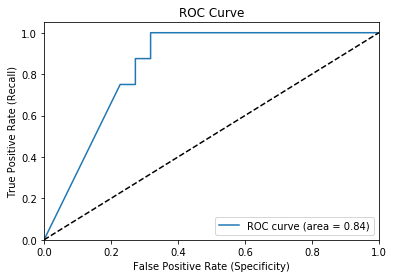

In [9]:
# ROC Curve
fpr, tpr , threshold = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#Specificity: How many negatives were identified as negative.
plt.xlabel('False Positive Rate (Specificity)')
#Recall: How many positives were identified as positive.
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
#code to save your model to disk and then to s3
import pickle
local_path = "/home/ubuntu" # temp path to export your model
bucket_name = "my-bucket-glen-c" # s3 key to save your network to

# save the model to disk
filename = 'GlenC_HW2_SGD.sav'
pickle.dump(clf, open(filename, 'wb'))

# list folder contents
!ls
 
# Upload to S3
#TO GET THIS WORKING, YOU MUST ASSIGN AN ADMIN ROLE TO YOUR EC2 INSTANCE
import boto3
s3 = boto3.resource('s3')
s3.Bucket(bucket_name).put_object(Key='GlenC_HW2_SGD.sav', Body=open('GlenC_HW2_SGD.sav'))

finalized_model.sav	intro_to_python_data_science_on_aws.ipynb
GCancian_HW2_Sub.ipynb	my_local_pickle.sav
GlenC_HW2_SGD.sav


s3.Object(bucket_name='my-bucket-glen-c', key='GlenC_HW2_SGD.sav')